# 05 — Rep Counting Baseline

Rule-based push-up counting using the elbow-angle state machine. Evaluate on labeled videos with visual verification and threshold sensitivity analysis.

In [1]:
import sys
sys.path.insert(0, "..")

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from pathlib import Path

from src.features.angles import compute_angle_sequence
from src.counting.state_machine import PushUpStateMachine, PushUpPhase

# Load manifest and YOLO keypoints
with open("../data/processed/keypoints/manifest.json") as f:
    manifest = json.load(f)

YOLO_DIR = Path("../data/processed/keypoints/yolo")
keypoints = {}
for vid_id in manifest:
    npy_path = YOLO_DIR / f"{vid_id}.npy"
    if npy_path.exists():
        keypoints[vid_id] = np.load(npy_path)

correct_ids = sorted([v for v, info in manifest.items() if info["label"] == "correct"])
incorrect_ids = sorted([v for v, info in manifest.items() if info["label"] == "incorrect"])

print(f"Loaded {len(keypoints)} videos")
print(f"  Correct: {len(correct_ids)}, Incorrect: {len(incorrect_ids)}")

Loaded 100 videos
  Correct: 50, Incorrect: 50


## Section 1: Run State Machine (Default Thresholds)

Run `PushUpStateMachine` on all videos with default 90 deg / 160 deg thresholds.

In [2]:
# Run state machine on all videos with default thresholds
results = {}
for vid_id, kps in keypoints.items():
    sm = PushUpStateMachine(down_threshold=90.0, up_threshold=160.0)
    angles = compute_angle_sequence(kps)
    phases = sm.label_sequence(kps)

    results[vid_id] = {
        "label": manifest[vid_id]["label"],
        "fps": manifest[vid_id]["fps"],
        "n_frames": len(kps),
        "rep_count": sm.count,
        "phases": phases,
        "elbow_angles": angles[:, 0],
        "angles": angles,
    }

rep_counts = [r["rep_count"] for r in results.values()]
print(f"Total videos processed: {len(results)}")
print(f"Rep count range: {min(rep_counts)} – {max(rep_counts)}")
print(f"Mean reps per video: {np.mean(rep_counts):.1f}")
print(f"Median reps: {np.median(rep_counts):.0f}")
print(f"Videos with 0 reps detected: {sum(1 for c in rep_counts if c == 0)}")

Total videos processed: 100
Rep count range: 0 – 2
Mean reps per video: 0.4
Median reps: 0
Videos with 0 reps detected: 58


## Section 2: Visual Verification

For 6 sample videos (3 correct, 3 incorrect), plot elbow angle over time with phase regions color-coded. This serves as qualitative ground truth.

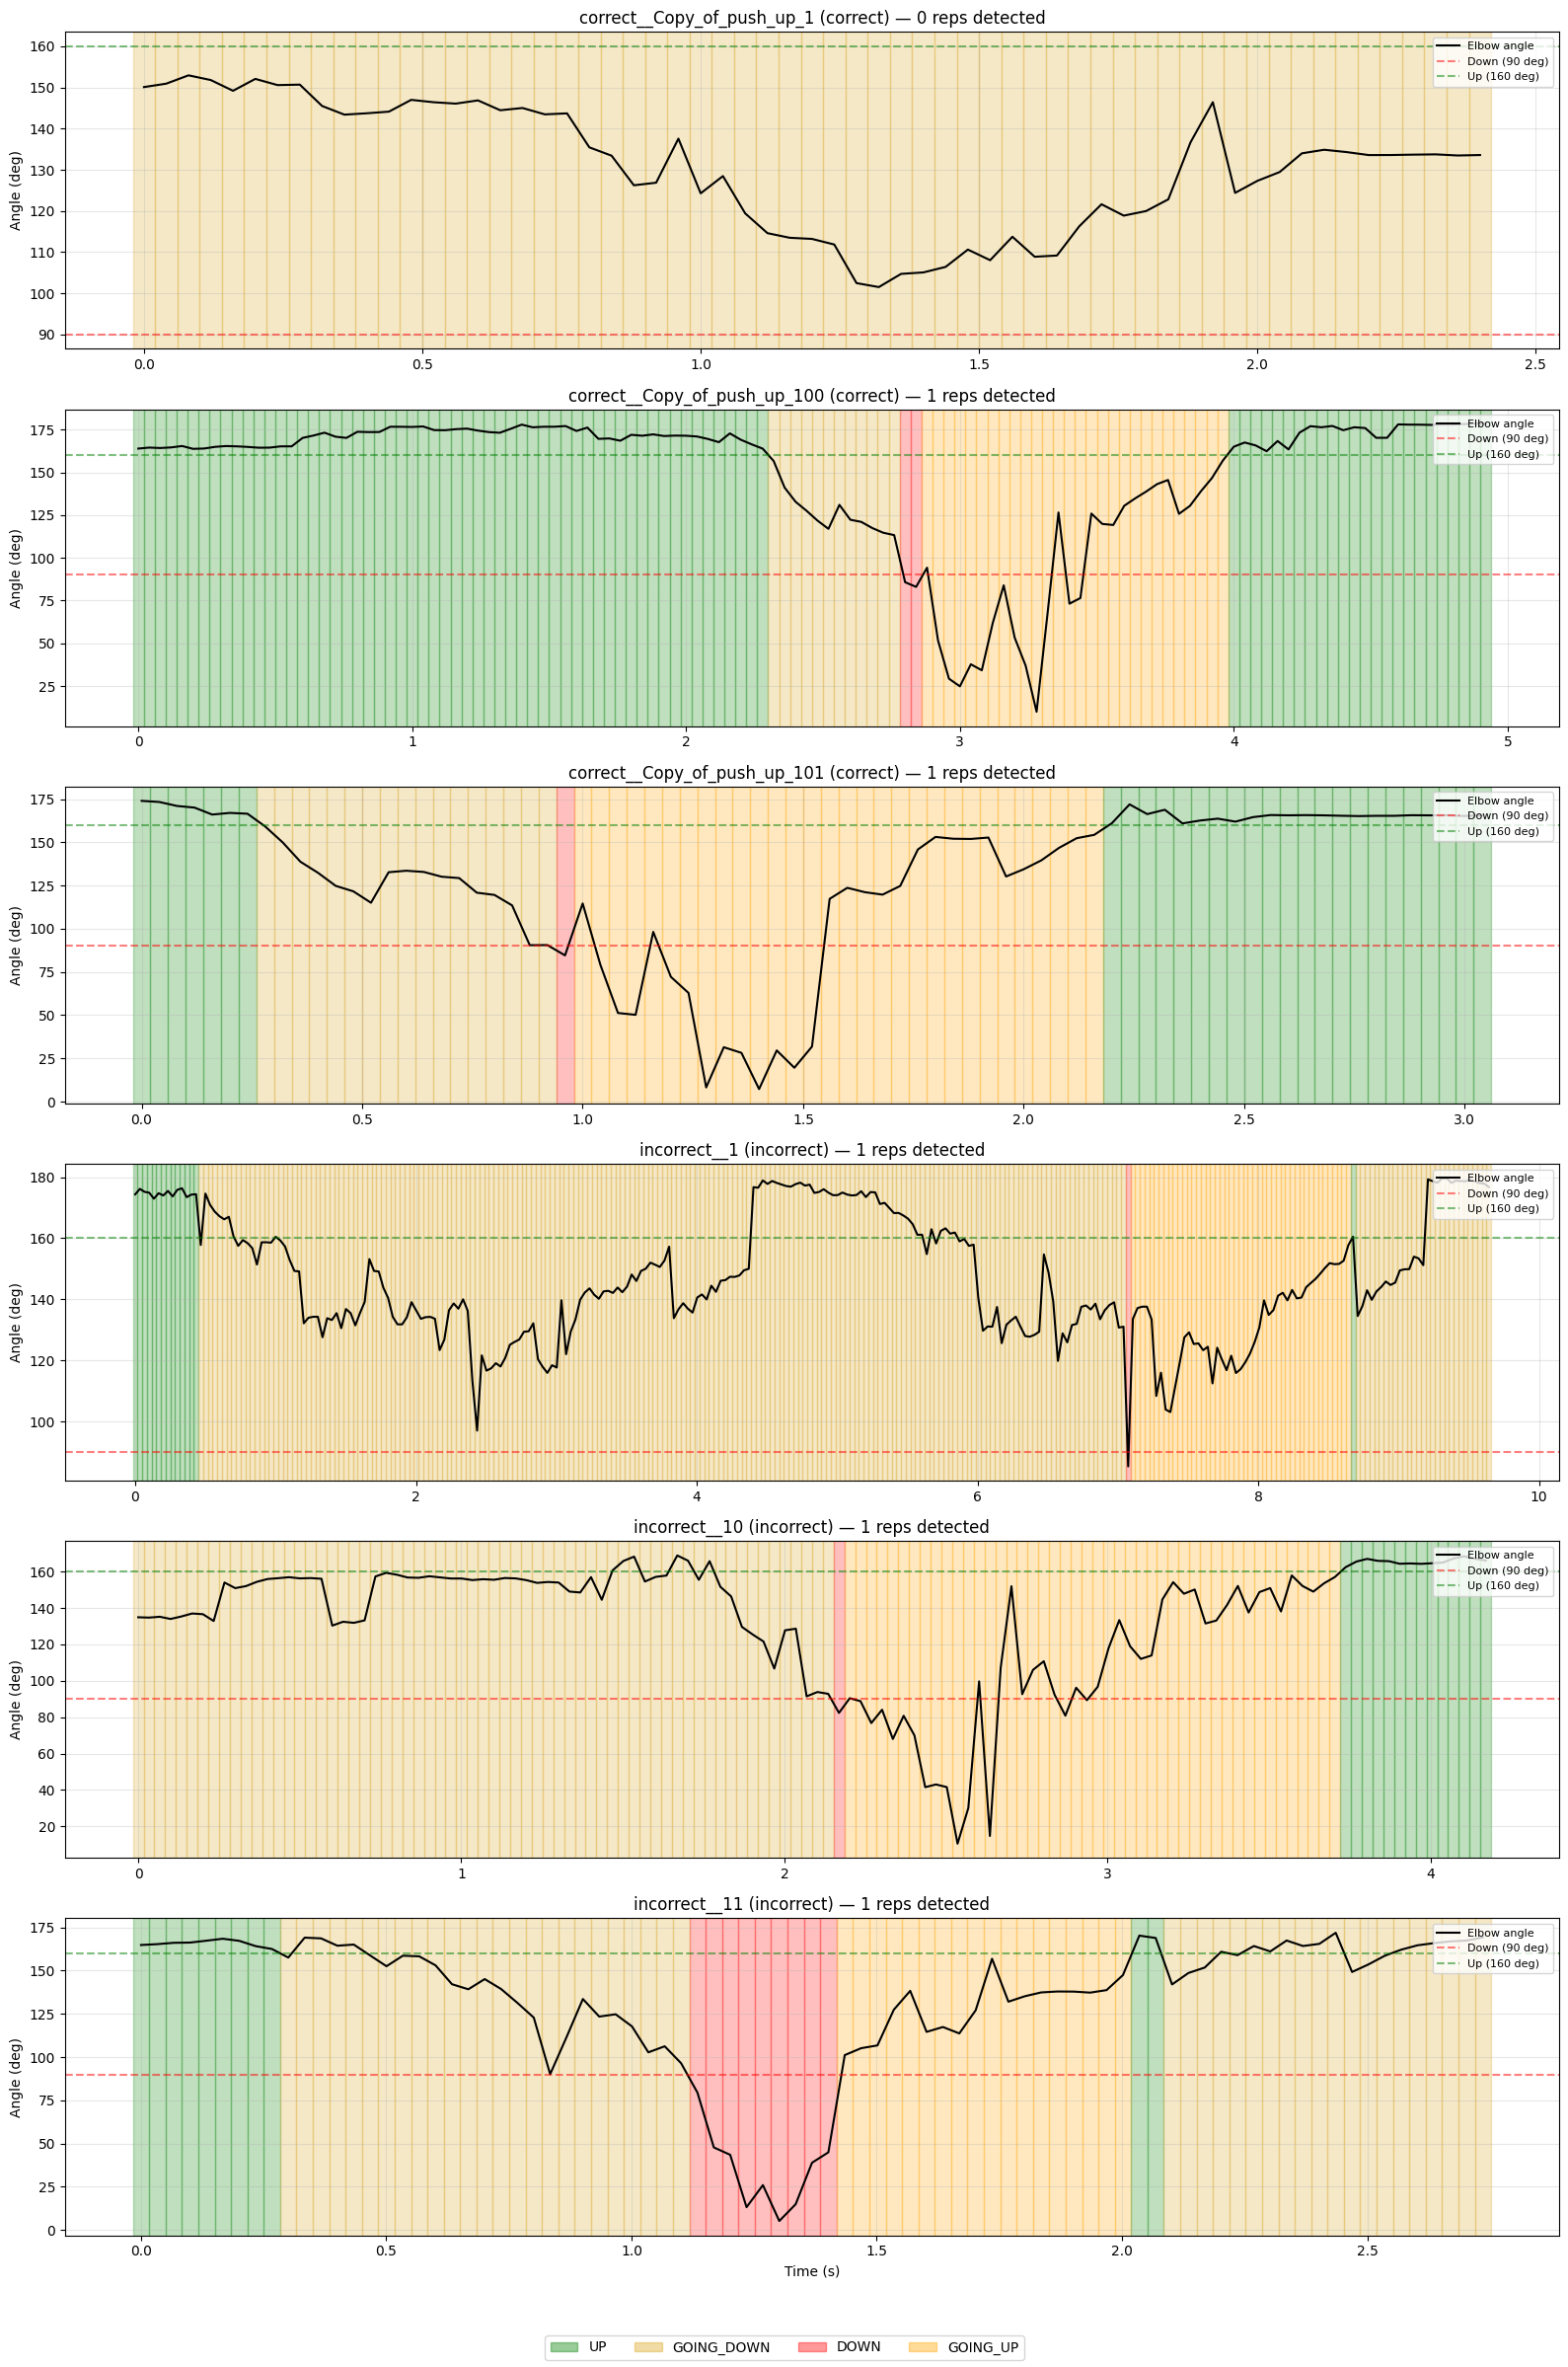

In [3]:
# Phase color mapping
PHASE_COLORS = {
    PushUpPhase.UP: "green",
    PushUpPhase.GOING_DOWN: "goldenrod",
    PushUpPhase.DOWN: "red",
    PushUpPhase.GOING_UP: "orange",
}

sample_correct = correct_ids[:3]
sample_incorrect = incorrect_ids[:3]
sample_ids = sample_correct + sample_incorrect

fig, axes = plt.subplots(len(sample_ids), 1, figsize=(16, 4 * len(sample_ids)))

for i, vid_id in enumerate(sample_ids):
    r = results[vid_id]
    fps = r["fps"]
    elbow = r["elbow_angles"]
    t = np.arange(len(elbow)) / fps
    phases = r["phases"]

    # Plot elbow angle
    axes[i].plot(t, elbow, "k-", linewidth=1.5, label="Elbow angle")

    # Color background by phase
    for j in range(len(phases)):
        axes[i].axvspan(
            t[j] - 0.5 / fps, t[j] + 0.5 / fps,
            color=PHASE_COLORS[phases[j]], alpha=0.25,
        )

    # Threshold lines
    axes[i].axhline(90, color="red", linestyle="--", alpha=0.5, label="Down (90 deg)")
    axes[i].axhline(160, color="green", linestyle="--", alpha=0.5, label="Up (160 deg)")

    axes[i].set_title(f"{vid_id} ({r['label']}) — {r['rep_count']} reps detected")
    axes[i].set_ylabel("Angle (deg)")
    axes[i].legend(loc="upper right", fontsize=8)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")

# Phase legend
patches = [mpatches.Patch(color=c, alpha=0.4, label=p.name) for p, c in PHASE_COLORS.items()]
fig.legend(handles=patches, loc="lower center", ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig("../outputs/figures/05_phase_verification.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 3: Threshold Sensitivity Analysis

Sweep down_threshold (70–110 deg) and up_threshold (140–175 deg). Heatmap shows how total rep counts change with threshold combinations.

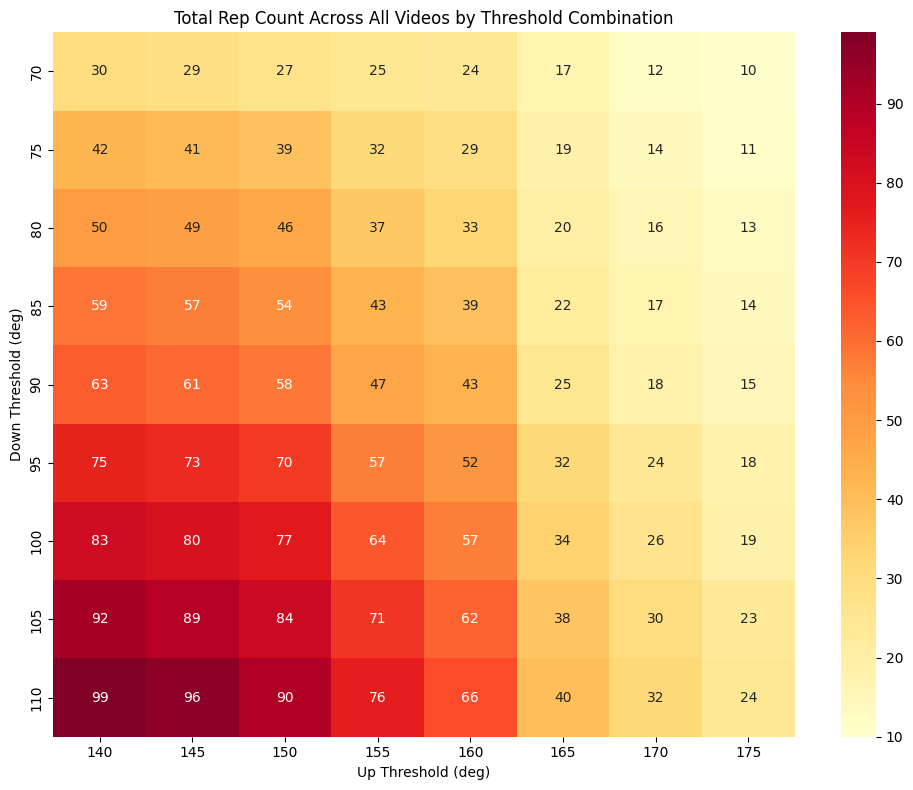


Stable threshold combinations (gradient below 9):
  Down=70 deg, Up=155 deg -> 25 reps
  Down=70 deg, Up=160 deg -> 24 reps
  Down=70 deg, Up=165 deg -> 17 reps
  Down=70 deg, Up=170 deg -> 12 reps
  Down=70 deg, Up=175 deg -> 10 reps
  Down=75 deg, Up=165 deg -> 19 reps
  Down=75 deg, Up=170 deg -> 14 reps
  Down=75 deg, Up=175 deg -> 11 reps
  Down=80 deg, Up=170 deg -> 16 reps
  Down=80 deg, Up=175 deg -> 13 reps
  Down=85 deg, Up=140 deg -> 59 reps
  Down=85 deg, Up=145 deg -> 57 reps
  Down=85 deg, Up=170 deg -> 17 reps
  Down=85 deg, Up=175 deg -> 14 reps
  Down=90 deg, Up=170 deg -> 18 reps
  Down=90 deg, Up=175 deg -> 15 reps
  Down=95 deg, Up=175 deg -> 18 reps
  Down=110 deg, Up=175 deg -> 24 reps


In [4]:
# Sweep thresholds
down_range = np.arange(70, 115, 5, dtype=float)
up_range = np.arange(140, 180, 5, dtype=float)
heatmap_data = np.zeros((len(down_range), len(up_range)))

for di, down_th in enumerate(down_range):
    for ui, up_th in enumerate(up_range):
        total_reps = 0
        for vid_id, kps in keypoints.items():
            sm = PushUpStateMachine(down_threshold=float(down_th), up_threshold=float(up_th))
            sm.label_sequence(kps)
            total_reps += sm.count
        heatmap_data[di, ui] = total_reps

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, fmt=".0f",
    xticklabels=[f"{x:.0f}" for x in up_range],
    yticklabels=[f"{y:.0f}" for y in down_range],
    cmap="YlOrRd", ax=ax,
)
ax.set_xlabel("Up Threshold (deg)")
ax.set_ylabel("Down Threshold (deg)")
ax.set_title("Total Rep Count Across All Videos by Threshold Combination")
plt.tight_layout()
plt.savefig("../outputs/figures/05_threshold_heatmap.png", dpi=120, bbox_inches="tight")
plt.show()

# Identify stable region (low gradient)
grad_y, grad_x = np.gradient(heatmap_data)
total_grad = np.abs(grad_y) + np.abs(grad_x)
threshold = np.percentile(total_grad, 25)
print(f"\nStable threshold combinations (gradient below {threshold:.0f}):")
for di in range(len(down_range)):
    for ui in range(len(up_range)):
        if total_grad[di, ui] <= threshold:
            print(f"  Down={down_range[di]:.0f} deg, Up={up_range[ui]:.0f} deg -> {heatmap_data[di, ui]:.0f} reps")

## Section 3b: Multi-Config Comparison

Try several threshold configurations and compare coverage (how many videos produce ≥1 rep), total reps, and mean reps per video.

             Config  Down (°)  Up (°)  Total Reps  Mean Reps/Video  Videos ≥1 Rep  Coverage (%)
   Default (90/160)        90     160          43             0.43             42          42.0
  Relaxed (100/150)       100     150          77             0.77             73          73.0
     Wide (110/145)       110     145          96             0.96             89          89.0
Very Wide (115/140)       115     140         104             1.04             94          94.0


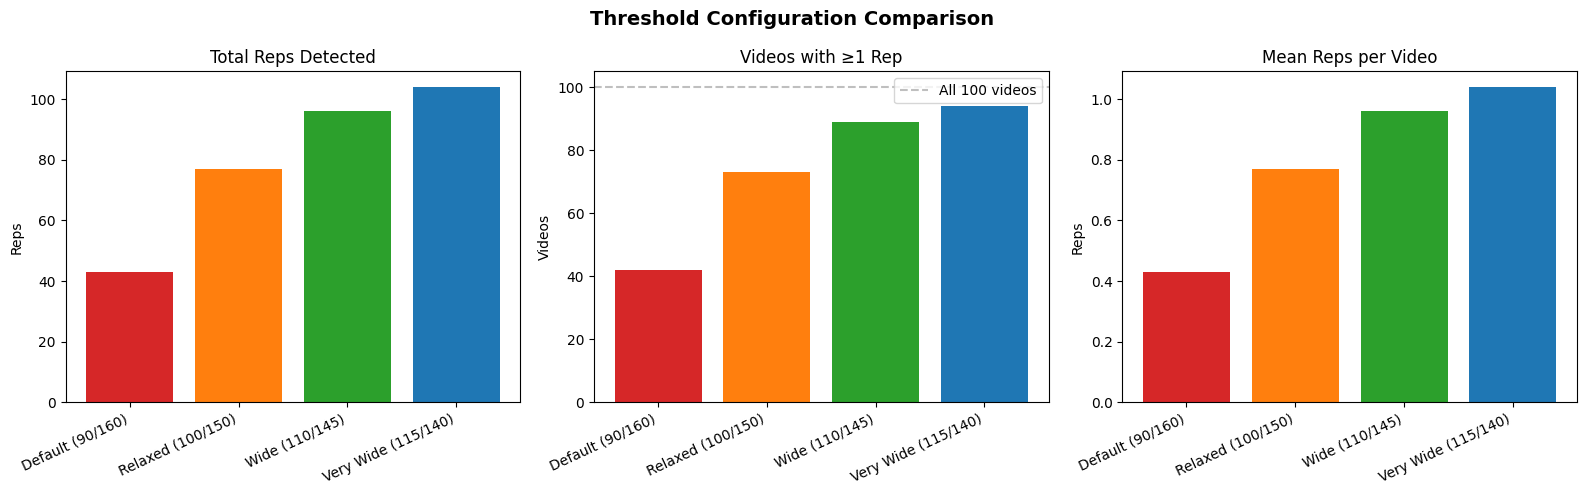

In [5]:
# Define threshold configurations to compare
CONFIGS = {
    "Default (90/160)": {"down": 90.0, "up": 160.0},
    "Relaxed (100/150)": {"down": 100.0, "up": 150.0},
    "Wide (110/145)": {"down": 110.0, "up": 145.0},
    "Very Wide (115/140)": {"down": 115.0, "up": 140.0},
}

config_results = {}
comparison = []

for name, cfg in CONFIGS.items():
    per_video = {}
    total_reps = 0
    videos_with_reps = 0

    for vid_id, kps in keypoints.items():
        sm = PushUpStateMachine(down_threshold=cfg["down"], up_threshold=cfg["up"])
        sm.label_sequence(kps)
        count = sm.count
        per_video[vid_id] = count
        total_reps += count
        if count > 0:
            videos_with_reps += 1

    config_results[name] = per_video
    counts = list(per_video.values())

    comparison.append({
        "Config": name,
        "Down (°)": int(cfg["down"]),
        "Up (°)": int(cfg["up"]),
        "Total Reps": total_reps,
        "Mean Reps/Video": round(np.mean(counts), 2),
        "Videos ≥1 Rep": videos_with_reps,
        "Coverage (%)": round(100 * videos_with_reps / len(keypoints), 1),
    })

df_configs = pd.DataFrame(comparison)
print(df_configs.to_string(index=False))

# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["#d62728", "#ff7f0e", "#2ca02c", "#1f77b4"]

axes[0].bar(range(len(CONFIGS)), df_configs["Total Reps"], color=colors)
axes[0].set_title("Total Reps Detected")
axes[0].set_ylabel("Reps")
axes[0].set_xticks(range(len(CONFIGS)))
axes[0].set_xticklabels(df_configs["Config"], rotation=25, ha="right")

axes[1].bar(range(len(CONFIGS)), df_configs["Videos ≥1 Rep"], color=colors)
axes[1].axhline(100, color="gray", linestyle="--", alpha=0.5, label="All 100 videos")
axes[1].set_title("Videos with ≥1 Rep")
axes[1].set_ylabel("Videos")
axes[1].set_xticks(range(len(CONFIGS)))
axes[1].set_xticklabels(df_configs["Config"], rotation=25, ha="right")
axes[1].legend()

axes[2].bar(range(len(CONFIGS)), df_configs["Mean Reps/Video"], color=colors)
axes[2].set_title("Mean Reps per Video")
axes[2].set_ylabel("Reps")
axes[2].set_xticks(range(len(CONFIGS)))
axes[2].set_xticklabels(df_configs["Config"], rotation=25, ha="right")

plt.suptitle("Threshold Configuration Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../outputs/figures/05_threshold_comparison.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 3c: Select Config & Before vs After

Change `SELECTED_CONFIG` below to try a different configuration. This re-runs the state machine and updates `results` for Sections 4–5.

In [7]:
# ---- Change this to try different configs from the table above ----
SELECTED_CONFIG = "Wide (110/145)"
# -------------------------------------------------------------------

sel_cfg = [c for c in comparison if c["Config"] == SELECTED_CONFIG][0]
sel_down = float(sel_cfg["Down (°)"])
sel_up = float(sel_cfg["Up (°)"])

print(f"Selected: {SELECTED_CONFIG}")
print(f"  Down threshold: {sel_down}°")
print(f"  Up threshold:   {sel_up}°")
print(f"  Coverage:       {sel_cfg['Coverage (%)']}%")
print(f"  Total reps:     {sel_cfg['Total Reps']}")

# Re-run state machine with selected thresholds (updates `results` for Sections 4-5)
results = {}
for vid_id, kps in keypoints.items():
    sm = PushUpStateMachine(down_threshold=sel_down, up_threshold=sel_up)
    angles = compute_angle_sequence(kps)
    phases = sm.label_sequence(kps)

    results[vid_id] = {
        "label": manifest[vid_id]["label"],
        "fps": manifest[vid_id]["fps"],
        "n_frames": len(kps),
        "rep_count": sm.count,
        "phases": phases,
        "elbow_angles": angles[:, 0],
        "angles": angles,
    }

# Before vs After
default_counts = config_results["Default (90/160)"]
selected_counts = config_results[SELECTED_CONFIG]

default_with_reps = sum(1 for c in default_counts.values() if c > 0)
selected_with_reps = sum(1 for c in selected_counts.values() if c > 0)

print(f"\n{'='*50}")
print(f"BEFORE — Default (90/160):")
print(f"  Videos with reps: {default_with_reps}/100")
print(f"  Total reps:       {sum(default_counts.values())}")
print(f"  Mean reps/video:  {np.mean(list(default_counts.values())):.2f}")
print(f"\nAFTER — {SELECTED_CONFIG}:")
print(f"  Videos with reps: {selected_with_reps}/100")
print(f"  Total reps:       {sum(selected_counts.values())}")
print(f"  Mean reps/video:  {np.mean(list(selected_counts.values())):.2f}")

# Videos that gained reps
gained = [v for v in keypoints if default_counts[v] == 0 and selected_counts[v] > 0]
print(f"\nVideos that went from 0 → ≥1 reps: {len(gained)}")
for v in gained[:8]:
    print(f"  {v}: 0 → {selected_counts[v]} reps")
if len(gained) > 8:
    print(f"  ... and {len(gained) - 8} more")

Selected: Wide (110/145)
  Down threshold: 110.0°
  Up threshold:   145.0°
  Coverage:       89.0%
  Total reps:     96

BEFORE — Default (90/160):
  Videos with reps: 42/100
  Total reps:       43
  Mean reps/video:  0.43

AFTER — Wide (110/145):
  Videos with reps: 89/100
  Total reps:       96
  Mean reps/video:  0.96

Videos that went from 0 → ≥1 reps: 47
  correct__Copy_of_push_up_1: 0 → 1 reps
  correct__Copy_of_push_up_116: 0 → 1 reps
  correct__Copy_of_push_up_127: 0 → 1 reps
  correct__Copy_of_push_up_129: 0 → 1 reps
  correct__Copy_of_push_up_131: 0 → 1 reps
  correct__Copy_of_push_up_132: 0 → 1 reps
  correct__Copy_of_push_up_133: 0 → 1 reps
  correct__Copy_of_push_up_140: 0 → 1 reps
  ... and 39 more


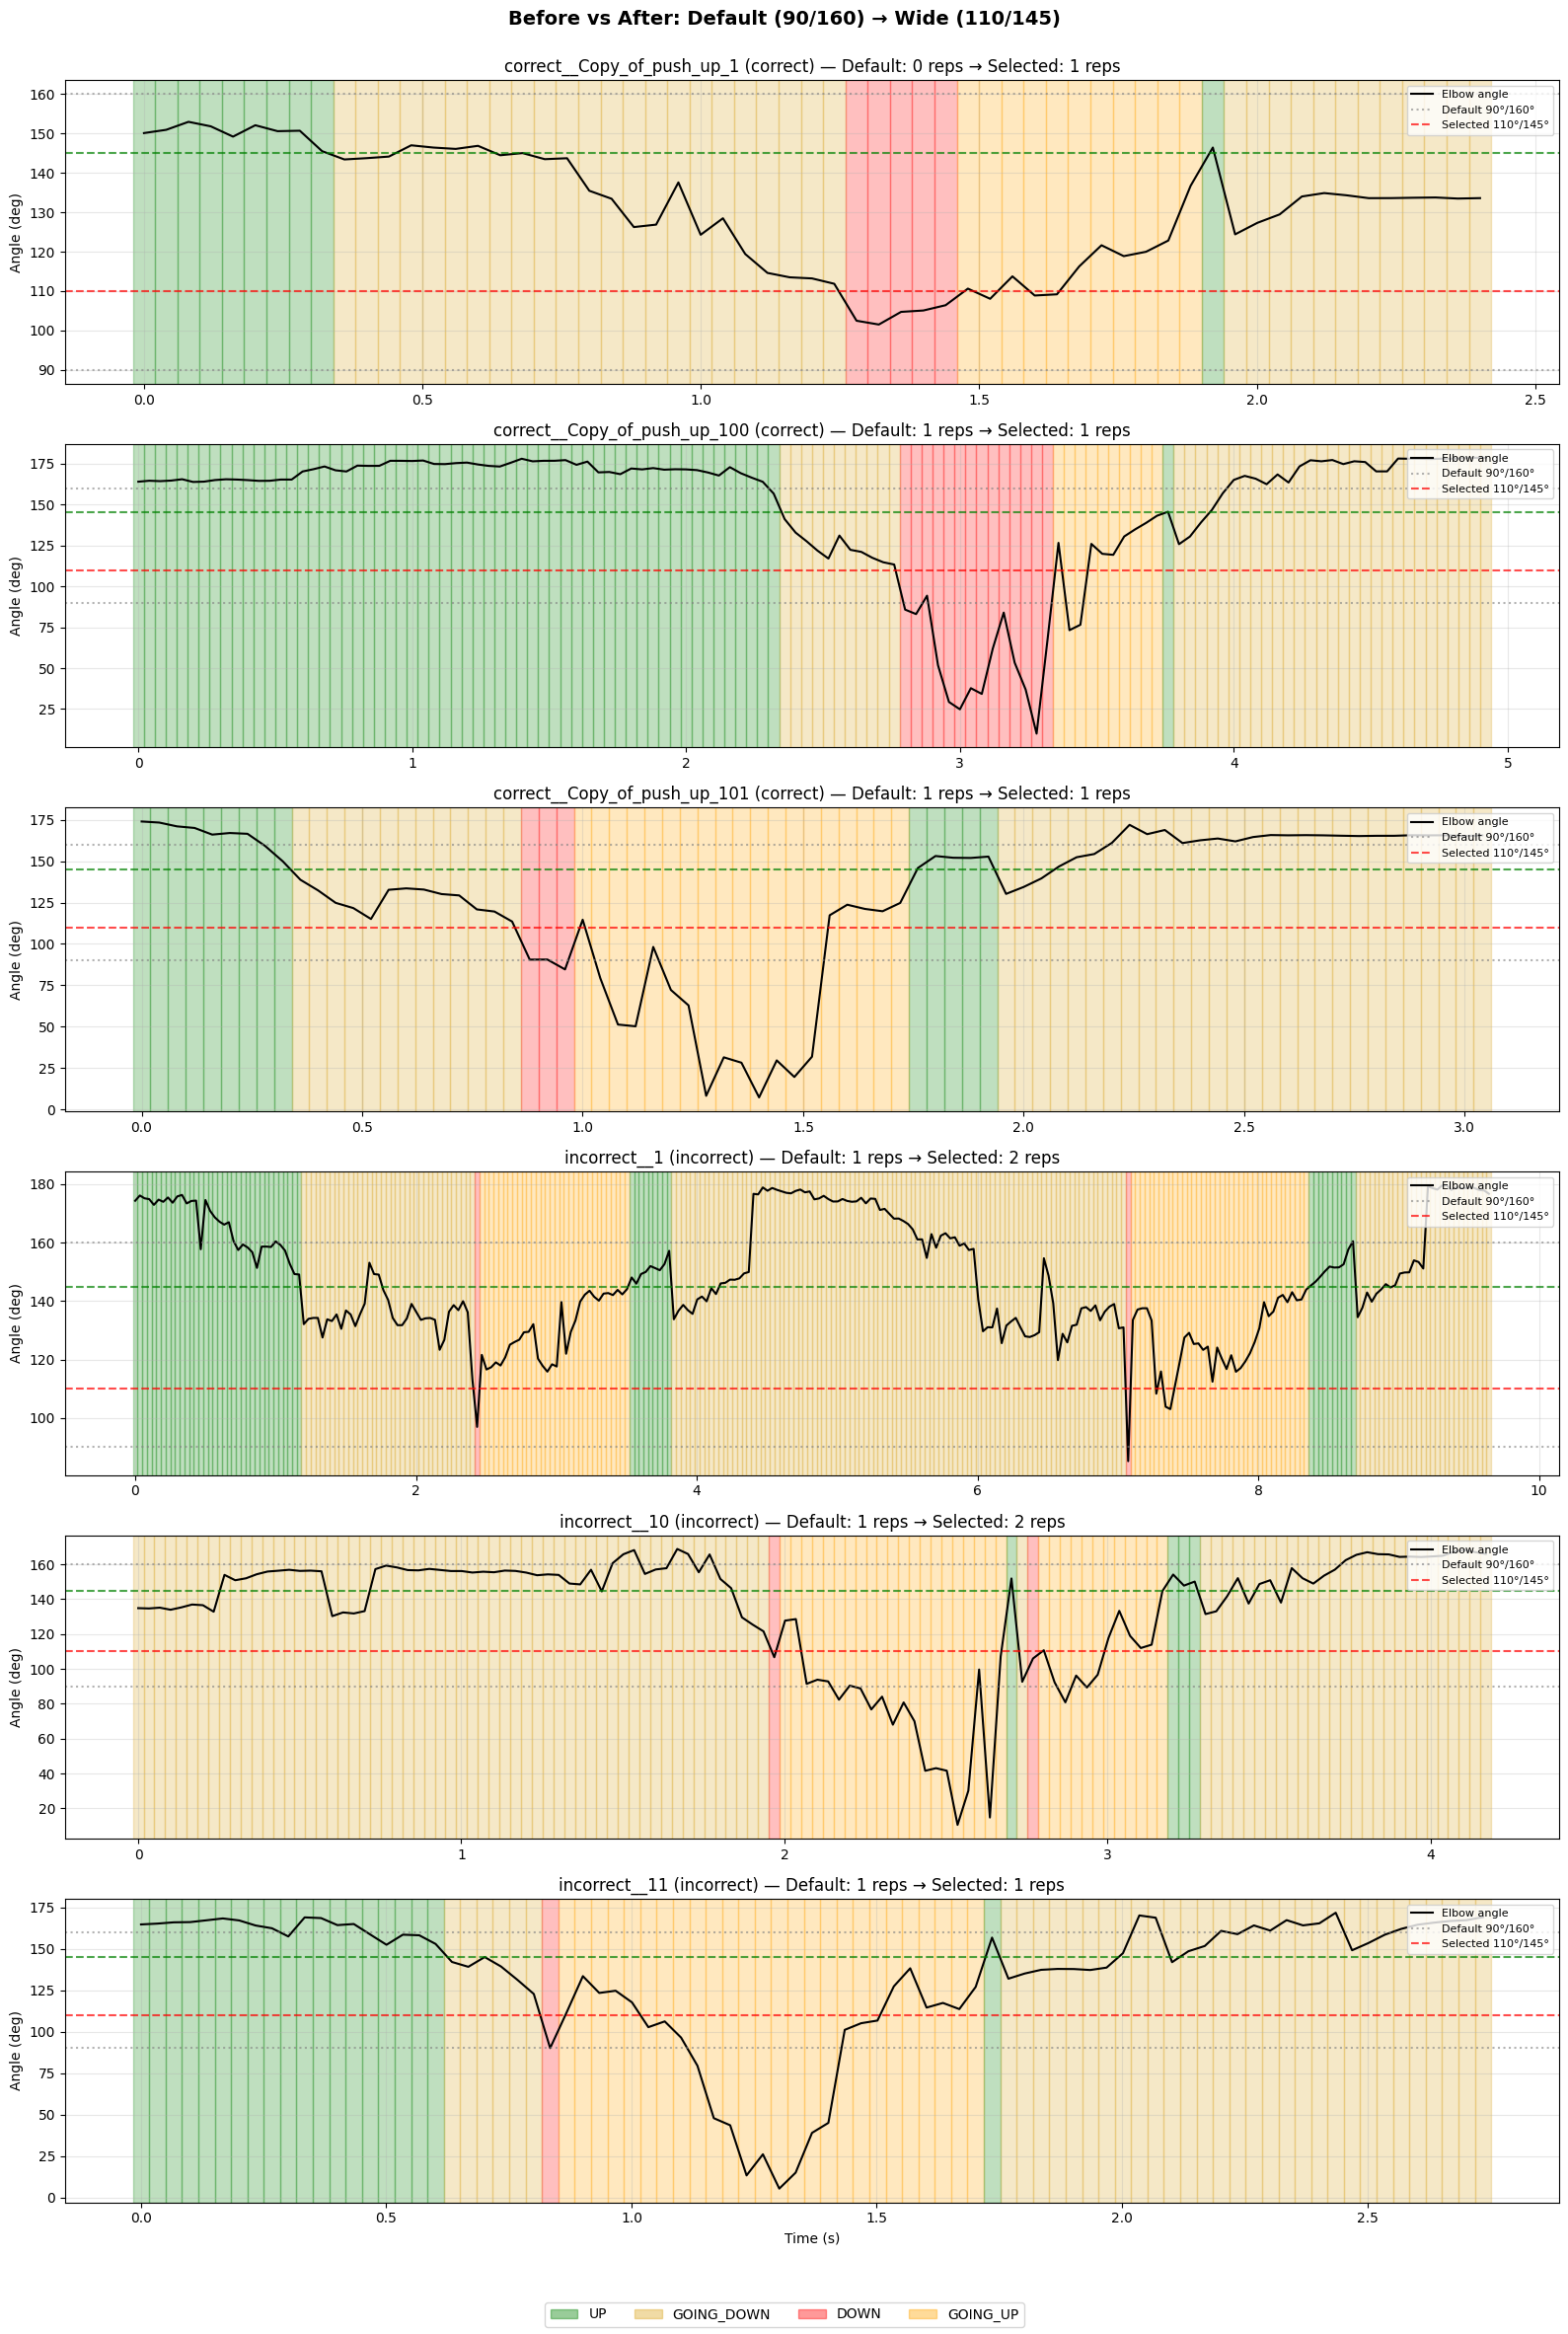

In [8]:
# Visual before/after: show 6 sample videos with default vs selected thresholds
sample_ids = correct_ids[:3] + incorrect_ids[:3]

fig, axes = plt.subplots(len(sample_ids), 1, figsize=(16, 4 * len(sample_ids)))

for i, vid_id in enumerate(sample_ids):
    r = results[vid_id]
    fps = r["fps"]
    elbow = r["elbow_angles"]
    t = np.arange(len(elbow)) / fps
    phases = r["phases"]

    axes[i].plot(t, elbow, "k-", linewidth=1.5, label="Elbow angle")

    # Color background by phase (selected config)
    for j in range(len(phases)):
        axes[i].axvspan(
            t[j] - 0.5 / fps, t[j] + 0.5 / fps,
            color=PHASE_COLORS[phases[j]], alpha=0.25,
        )

    # Default thresholds (gray dashed)
    axes[i].axhline(90, color="gray", linestyle=":", alpha=0.6, label="Default 90°/160°")
    axes[i].axhline(160, color="gray", linestyle=":", alpha=0.6)

    # Selected thresholds (colored dashed)
    axes[i].axhline(sel_down, color="red", linestyle="--", alpha=0.7,
                     label=f"Selected {sel_down:.0f}°/{sel_up:.0f}°")
    axes[i].axhline(sel_up, color="green", linestyle="--", alpha=0.7)

    default_count = default_counts[vid_id]
    selected_count = selected_counts[vid_id]
    axes[i].set_title(
        f"{vid_id} ({r['label']}) — Default: {default_count} reps → Selected: {selected_count} reps"
    )
    axes[i].set_ylabel("Angle (deg)")
    axes[i].legend(loc="upper right", fontsize=8)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")

patches = [mpatches.Patch(color=c, alpha=0.4, label=p.name) for p, c in PHASE_COLORS.items()]
fig.legend(handles=patches, loc="lower center", ncol=4, fontsize=10)
plt.suptitle(f"Before vs After: Default (90/160) → {SELECTED_CONFIG}", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("../outputs/figures/05_before_after_comparison.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 3d: Random Sample Validation

Randomly sample videos and plot elbow angle curves. Visually count reps in each plot and compare to the state machine count. Re-run this cell to get a different random sample.

In [ ]:
# Random sample of videos for manual validation
# Re-run this cell to get a new random sample
N_SAMPLES = 10
rng = np.random.default_rng()
sample = rng.choice(list(results.keys()), size=N_SAMPLES, replace=False)

fig, axes = plt.subplots(N_SAMPLES, 1, figsize=(16, 3.5 * N_SAMPLES))

for i, vid_id in enumerate(sample):
    r = results[vid_id]
    fps = r["fps"]
    elbow = r["elbow_angles"]
    t = np.arange(len(elbow)) / fps
    phases = r["phases"]

    axes[i].plot(t, elbow, "k-", linewidth=1.5)

    # Color background by phase
    for j in range(len(phases)):
        axes[i].axvspan(
            t[j] - 0.5 / fps, t[j] + 0.5 / fps,
            color=PHASE_COLORS[phases[j]], alpha=0.25,
        )

    # Threshold lines
    axes[i].axhline(sel_down, color="red", linestyle="--", alpha=0.5)
    axes[i].axhline(sel_up, color="green", linestyle="--", alpha=0.5)

    duration = len(elbow) / fps
    axes[i].set_title(
        f"{vid_id}  |  {r['label']}  |  {duration:.1f}s ({len(elbow)} frames)  |  "
        f"Detected: {r['rep_count']} reps  |  Elbow range: {elbow.min():.0f}°–{elbow.max():.0f}°",
        fontsize=10,
    )
    axes[i].set_ylabel("Angle (°)")
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")

patches = [mpatches.Patch(color=c, alpha=0.4, label=p.name) for p, c in PHASE_COLORS.items()]
fig.legend(handles=patches, loc="lower center", ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.savefig("../outputs/figures/05_random_sample_validation.png", dpi=120, bbox_inches="tight")
plt.show()

# Summary table for this sample
print(f"\n{'Video ID':<45s} {'Label':<12s} {'Duration':>8s} {'Frames':>7s} {'Reps':>5s} {'Elbow Range':>12s}")
print("-" * 95)
for vid_id in sample:
    r = results[vid_id]
    dur = len(r["elbow_angles"]) / r["fps"]
    emin, emax = r["elbow_angles"].min(), r["elbow_angles"].max()
    print(f"{vid_id:<45s} {r['label']:<12s} {dur:>7.1f}s {len(r['elbow_angles']):>7d} {r['rep_count']:>5d} {emin:>5.0f}°–{emax:.0f}°")

## Section 3e: Test on External Videos

Download a YouTube video (or point to a local file) and run the full pipeline: pose estimation → angle extraction → state machine → plot. Good for validating multi-rep detection.

**Prerequisites:** `uv tool install yt-dlp` (one-time)

In [15]:
# ---- Configuration ----
# Option A: YouTube URL(s) — will be downloaded automatically
YOUTUBE_URLS = [
    # "https://www.youtube.com/watch?v=EXAMPLE",
    "https://www.youtube.com/watch?v=hIkeJVV-Djk"
]

# Option B: Local video file path(s) — skip download
LOCAL_VIDEOS = [
    # "../data/raw/stress_test/my_pushups.mp4",
]

# Optional: trim YouTube downloads to a time range (None = full video)
# Format: "*START-END" e.g. "*0:05-0:30" for 5s to 30s
TIME_RANGE = None  # e.g. "*0:00-0:30"
# ------------------------

import subprocess
import cv2
from src.pose_estimation.yolo_estimator import YoloEstimator

EXTERNAL_DIR = Path("../data/raw/external_test")
EXTERNAL_DIR.mkdir(parents=True, exist_ok=True)

# Download YouTube videos
video_paths = list(LOCAL_VIDEOS)
for url in YOUTUBE_URLS:
    cmd = [
        "yt-dlp", "--merge-output-format", "mp4",
        "-o", str(EXTERNAL_DIR / "%(title)s.%(ext)s"),
    ]
    if TIME_RANGE:
        cmd += ["--download-sections", TIME_RANGE]
    cmd.append(url)
    print(f"Downloading: {url}")
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"  Error: {result.stderr.strip()}")
    else:
        # Find the downloaded file
        for line in result.stdout.splitlines():
            if "Destination:" in line or "has already been downloaded" in line:
                print(f"  {line.strip()}")
        # Glob for new mp4 files
        for f in sorted(EXTERNAL_DIR.glob("*.mp4")):
            if str(f) not in video_paths:
                video_paths.append(str(f))

if not video_paths:
    print("No videos to test. Set YOUTUBE_URLS or LOCAL_VIDEOS above.")
else:
    print(f"\nVideos to analyze: {len(video_paths)}")
    for p in video_paths:
        print(f"  {p}")

Downloading: https://www.youtube.com/watch?v=hIkeJVV-Djk
  [download] Destination: ../data/raw/external_test/Most Push-Ups in 1 MINUTE ! ( WORLD RECORD ).f399.mp4
  [download] Destination: ../data/raw/external_test/Most Push-Ups in 1 MINUTE ! ( WORLD RECORD ).f251.webm

Videos to analyze: 2
  ../data/raw/external_test/How to do a Push-Up ｜ Proper Form & Technique ｜ NASM.mp4
  ../data/raw/external_test/Most Push-Ups in 1 MINUTE ! ( WORLD RECORD ).mp4



Video: How to do a Push-Up ｜ Proper Form & Technique ｜ NASM.mp4
  325 frames @ 24.0 FPS (13.6s)
  Detection rate: 325/325 (100%)
  Reps detected: 4
    Rep 1: frames 24–70 (1.9s)
    Rep 2: frames 73–152 (3.3s)
    Rep 3: frames 153–232 (3.3s)
    Rep 4: frames 258–304 (1.9s)


/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_88642/287751864.py:78: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ikhyvicky/CS604/pushup-tracker/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


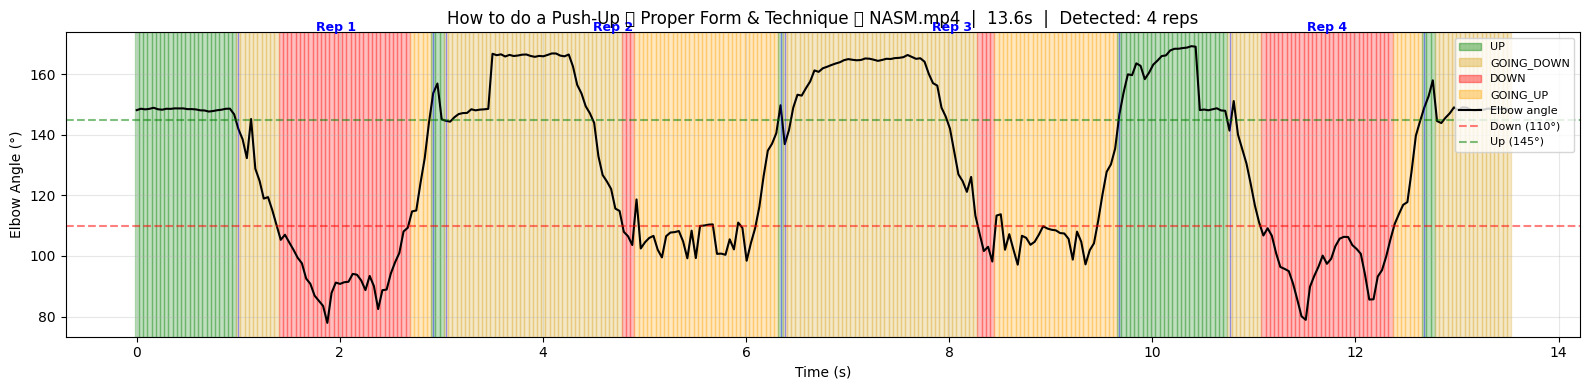


Video: Most Push-Ups in 1 MINUTE ! ( WORLD RECORD ).mp4
  4214 frames @ 55.0 FPS (76.6s)
  Detection rate: 3674/4214 (87%)
  Reps detected: 36
    Rep 1: frames 0–13 (0.2s)
    Rep 2: frames 14–20 (0.1s)
    Rep 3: frames 28–58 (0.5s)
    Rep 4: frames 61–71 (0.2s)
    Rep 5: frames 78–117 (0.7s)
    Rep 6: frames 122–129 (0.1s)
    Rep 7: frames 145–163 (0.3s)
    Rep 8: frames 167–174 (0.1s)
    Rep 9: frames 235–427 (3.5s)
    Rep 10: frames 430–460 (0.5s)
    Rep 11: frames 464–489 (0.5s)
    Rep 12: frames 494–520 (0.5s)
    Rep 13: frames 523–550 (0.5s)
    Rep 14: frames 555–582 (0.5s)
    Rep 15: frames 584–613 (0.5s)
    Rep 16: frames 617–2053 (26.1s)
    Rep 17: frames 2077–2121 (0.8s)
    Rep 18: frames 2126–2154 (0.5s)
    Rep 19: frames 2155–2188 (0.6s)
    Rep 20: frames 2196–2234 (0.7s)
    Rep 21: frames 2235–2268 (0.6s)
    Rep 22: frames 2271–2308 (0.7s)
    Rep 23: frames 2310–2352 (0.8s)
    Rep 24: frames 2358–2450 (1.7s)
    Rep 25: frames 2452–2495 (0.8s)
    R

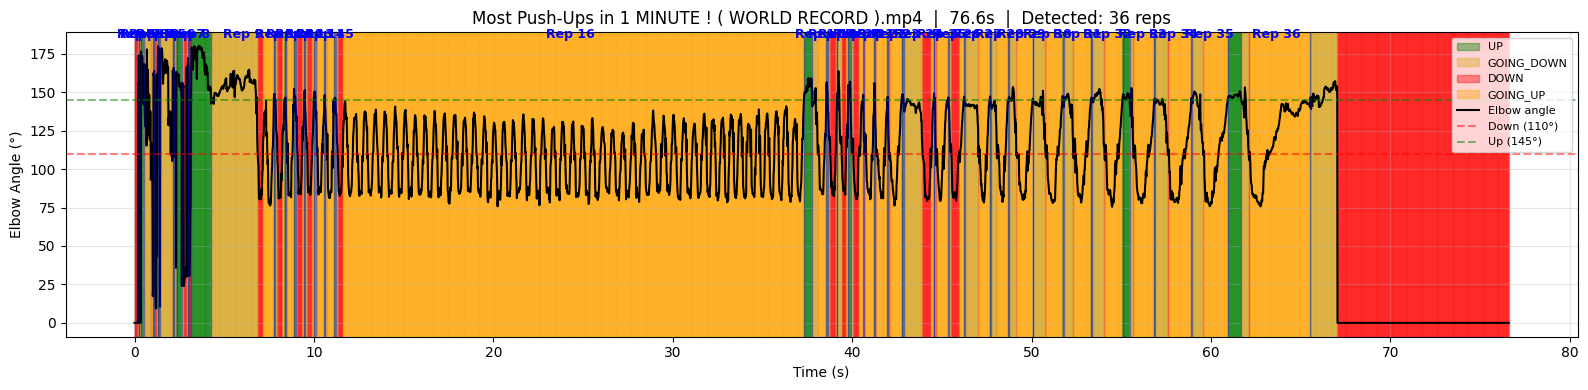

In [16]:
# Run pose estimation + state machine on each video and plot
if video_paths:
    estimator = YoloEstimator()

    for vpath in video_paths:
        cap = cv2.VideoCapture(vpath)
        if not cap.isOpened():
            print(f"Cannot open: {vpath}")
            continue

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"\n{'='*60}")
        print(f"Video: {Path(vpath).name}")
        print(f"  {total_frames} frames @ {fps:.1f} FPS ({total_frames/fps:.1f}s)")

        # Extract keypoints frame by frame
        all_kps = []
        detected = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            result = estimator.predict_frame(frame)
            if result.detected:
                all_kps.append(result.unified_keypoints)
                detected += 1
            else:
                # Use zeros for undetected frames to keep alignment
                all_kps.append(np.zeros((12, 3), dtype=np.float32))
        cap.release()

        kps_array = np.stack(all_kps)  # (T, 12, 3)
        print(f"  Detection rate: {detected}/{len(all_kps)} ({100*detected/len(all_kps):.0f}%)")

        # Run state machine with selected thresholds
        sm = PushUpStateMachine(down_threshold=sel_down, up_threshold=sel_up)
        angles = compute_angle_sequence(kps_array)
        phases = sm.label_sequence(kps_array)
        boundaries = sm.rep_boundaries

        print(f"  Reps detected: {sm.count}")
        for bi, (start, end) in enumerate(boundaries):
            print(f"    Rep {bi+1}: frames {start}–{end} ({(end-start)/fps:.1f}s)")

        # Plot
        elbow = angles[:, 0]
        t = np.arange(len(elbow)) / fps

        fig, ax = plt.subplots(figsize=(16, 4))
        ax.plot(t, elbow, "k-", linewidth=1.5, label="Elbow angle")

        for j in range(len(phases)):
            ax.axvspan(
                t[j] - 0.5 / fps, t[j] + 0.5 / fps,
                color=PHASE_COLORS[phases[j]], alpha=0.25,
            )

        # Mark rep boundaries
        for bi, (start, end) in enumerate(boundaries):
            ax.axvline(start / fps, color="blue", linestyle="-", alpha=0.4, linewidth=1)
            ax.axvline(end / fps, color="blue", linestyle="-", alpha=0.4, linewidth=1)
            mid_t = (start + end) / 2 / fps
            ax.text(mid_t, elbow.max() + 5, f"Rep {bi+1}", ha="center", fontsize=9,
                    color="blue", fontweight="bold")

        ax.axhline(sel_down, color="red", linestyle="--", alpha=0.5, label=f"Down ({sel_down:.0f}°)")
        ax.axhline(sel_up, color="green", linestyle="--", alpha=0.5, label=f"Up ({sel_up:.0f}°)")

        ax.set_title(f"{Path(vpath).name}  |  {total_frames/fps:.1f}s  |  Detected: {sm.count} reps")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Elbow Angle (°)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

        patches = [mpatches.Patch(color=c, alpha=0.4, label=p.name) for p, c in PHASE_COLORS.items()]
        ax.legend(handles=patches + ax.get_legend_handles_labels()[0][:3], loc="upper right", fontsize=8)
        plt.tight_layout()
        plt.show()

## Section 4: Per-Video Summary (Using Selected Config)

Table of all videos with label, duration, frame count, detected reps, and elbow angle range. Uses the thresholds selected in Section 3c above.

Videos with 0 reps detected: 11
                      video_id     label  n_frames  elbow_min  elbow_max
  correct__Copy_of_push_up_165   correct       100  68.300003 156.699997
  correct__Copy_of_push_up_174   correct       131 112.400002 177.899994
   correct__Copy_of_push_up_79   correct        45 124.900002 180.000000
incorrect__Copy_of_push_up_155 incorrect        60 112.300003 145.100006
incorrect__Copy_of_push_up_156 incorrect        47 110.099998 147.399994
incorrect__Copy_of_push_up_166 incorrect       172 116.099998 168.300003
incorrect__Copy_of_push_up_167 incorrect        85 114.099998 169.500000
incorrect__Copy_of_push_up_168 incorrect        90 119.900002 164.600006
incorrect__Copy_of_push_up_171 incorrect       397 116.699997 180.000000
 incorrect__Copy_of_push_up_57 incorrect        75 127.500000 164.199997
 incorrect__Copy_of_push_up_58 incorrect        84 123.199997 160.600006

Rep count statistics by label:
           count  mean   std  min  25%  50%  75%  max
label 

/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_88642/683999586.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_summary, x="label", y="rep_count", ax=axes[0],
/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_88642/683999586.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_summary, x="label", y="elbow_range", ax=axes[1],


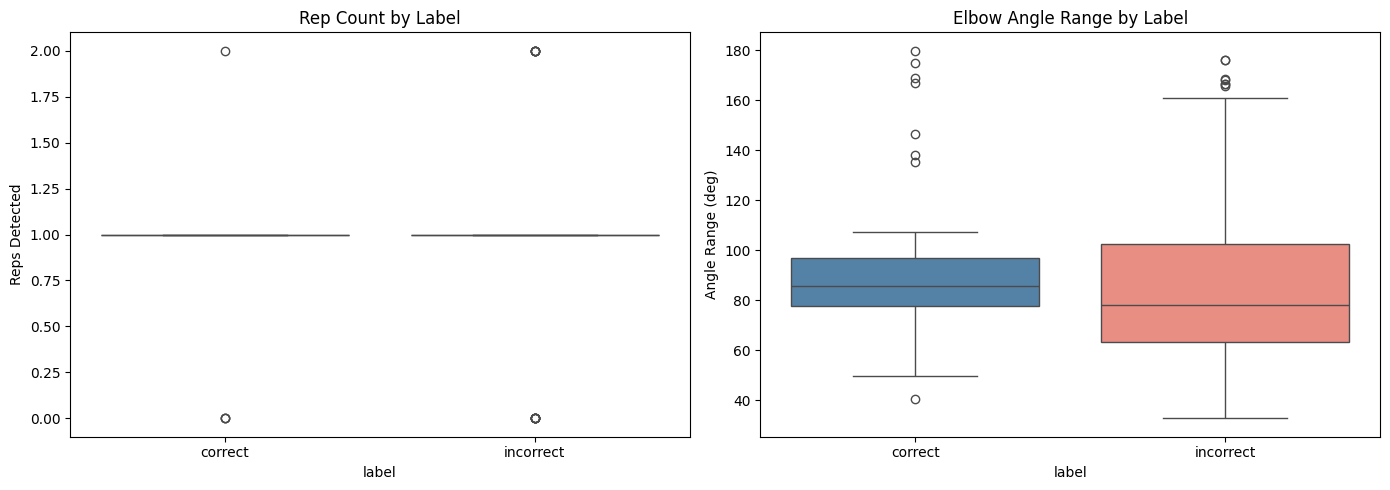

In [9]:
# Build summary table
summary_records = []
for vid_id, r in results.items():
    elbow = r["elbow_angles"]
    summary_records.append({
        "video_id": vid_id,
        "label": r["label"],
        "duration_s": manifest[vid_id]["duration_s"],
        "n_frames": r["n_frames"],
        "rep_count": r["rep_count"],
        "elbow_min": round(elbow.min(), 1),
        "elbow_max": round(elbow.max(), 1),
        "elbow_range": round(elbow.max() - elbow.min(), 1),
        "elbow_mean": round(elbow.mean(), 1),
    })

df_summary = pd.DataFrame(summary_records).sort_values("video_id").reset_index(drop=True)

# Flag videos with 0 reps
zero_rep = df_summary[df_summary["rep_count"] == 0]
print(f"Videos with 0 reps detected: {len(zero_rep)}")
if len(zero_rep) > 0:
    print(zero_rep[["video_id", "label", "n_frames", "elbow_min", "elbow_max"]].to_string(index=False))

# Compare correct vs incorrect
print("\nRep count statistics by label:")
print(df_summary.groupby("label")["rep_count"].describe().round(2).to_string())

# Box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_summary, x="label", y="rep_count", ax=axes[0],
            palette={"correct": "steelblue", "incorrect": "salmon"})
axes[0].set_title("Rep Count by Label")
axes[0].set_ylabel("Reps Detected")

sns.boxplot(data=df_summary, x="label", y="elbow_range", ax=axes[1],
            palette={"correct": "steelblue", "incorrect": "salmon"})
axes[1].set_title("Elbow Angle Range by Label")
axes[1].set_ylabel("Angle Range (deg)")

plt.tight_layout()
plt.savefig("../outputs/figures/05_rep_count_summary.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 5: Phase Duration Analysis (Using Selected Config)

Analyze time spent in each phase per rep. Incorrect form may show asymmetric phase durations compared to correct form.

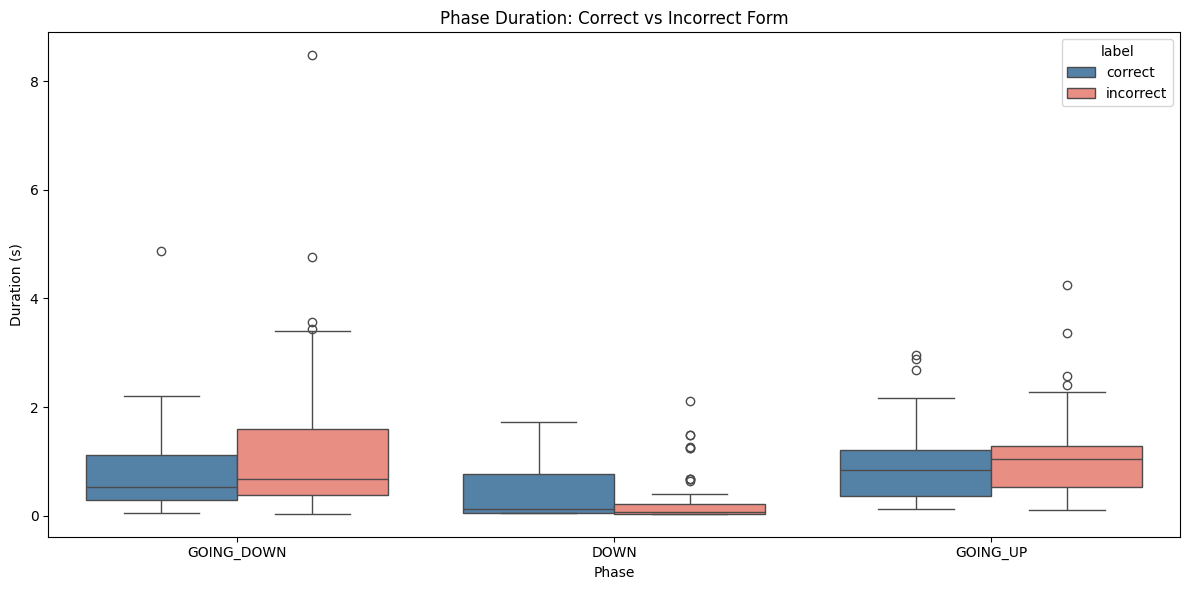

Phase duration statistics (seconds):
                      count   mean    std    min    25%    50%    75%   max
label     phase                                                            
correct   DOWN         49.0  0.399  0.487  0.040  0.040  0.120  0.760  1.72
          GOING_DOWN   78.0  0.745  0.715  0.040  0.280  0.520  1.110  4.88
          GOING_UP     49.0  0.942  0.743  0.120  0.360  0.840  1.200  2.96
incorrect DOWN         48.0  0.304  0.492  0.033  0.033  0.067  0.210  2.12
          GOING_DOWN   79.0  1.198  1.332  0.033  0.384  0.667  1.602  8.48
          GOING_UP     48.0  1.086  0.809  0.100  0.528  1.034  1.276  4.24


In [10]:
# Analyze phase durations
phase_records = []
for vid_id, r in results.items():
    fps = r["fps"]
    phases = r["phases"]
    if not phases:
        continue

    # Count consecutive frames in each phase
    current_phase = phases[0]
    run_length = 1

    for j in range(1, len(phases)):
        if phases[j] == current_phase:
            run_length += 1
        else:
            phase_records.append({
                "video_id": vid_id,
                "label": r["label"],
                "phase": current_phase.name,
                "duration_s": run_length / fps,
            })
            current_phase = phases[j]
            run_length = 1

    # Last run
    phase_records.append({
        "video_id": vid_id,
        "label": r["label"],
        "phase": current_phase.name,
        "duration_s": run_length / fps,
    })

df_phases = pd.DataFrame(phase_records)

# Focus on transitional phases (exclude long UP segments at start/end)
transition_phases = df_phases[df_phases["phase"].isin(["GOING_DOWN", "DOWN", "GOING_UP"])]

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=transition_phases, x="phase", y="duration_s", hue="label",
    order=["GOING_DOWN", "DOWN", "GOING_UP"], ax=ax,
    palette={"correct": "steelblue", "incorrect": "salmon"},
)
ax.set_title("Phase Duration: Correct vs Incorrect Form")
ax.set_xlabel("Phase")
ax.set_ylabel("Duration (s)")
plt.tight_layout()
plt.savefig("../outputs/figures/05_phase_duration.png", dpi=120, bbox_inches="tight")
plt.show()

# Summary statistics
print("Phase duration statistics (seconds):")
print(
    transition_phases.groupby(["label", "phase"])["duration_s"]
    .describe()
    .round(3)
    .to_string()
)

## Save Results

In [17]:
# Save per-video rep counts and stats
RESULTS_DIR = Path("../outputs/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

df_summary.to_csv(RESULTS_DIR / "rep_counting_baseline.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'rep_counting_baseline.csv'} ({len(df_summary)} rows)")
print(f"Config used: {SELECTED_CONFIG} (down={sel_down}°, up={sel_up}°)")

# Save config comparison
df_configs.to_csv(RESULTS_DIR / "threshold_comparison.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'threshold_comparison.csv'}")

df_summary.head(10)

Saved: ../outputs/results/rep_counting_baseline.csv (100 rows)
Config used: Wide (110/145) (down=110.0°, up=145.0°)
Saved: ../outputs/results/threshold_comparison.csv


,video_id,label,duration_s,n_frames,rep_count,elbow_min,elbow_max,elbow_range,elbow_mean
0,correct__Copy_of_push_up_1,correct,2.44,61,1,101.500000,152.899994,51.400002,130.699997
1,correct__Copy_of_push_up_100,correct,4.96,124,1,9.900000,178.600006,168.699997,148.199997
2,correct__Copy_of_push_up_101,correct,3.08,77,1,7.300000,174.000000,166.699997,129.199997
3,correct__Copy_of_push_up_102,correct,3.32,83,1,0.000000,179.800003,179.800003,138.600006
4,correct__Copy_of_push_up_113,correct,3.08,77,1,2.300000,177.199997,174.899994,126.000000
5,correct__Copy_of_push_up_114,correct,3.52,88,2,44.299999,179.500000,135.199997,144.500000
6,correct__Copy_of_push_up_115,correct,5.48,137,1,41.700001,180.000000,138.199997,152.300003
7,correct__Copy_of_push_up_116,correct,3.00,75,1,93.400002,171.300003,77.900002,149.899994
8,correct__Copy_of_push_up_127,correct,3.64,91,1,73.599998,172.800003,99.199997,128.100006
9,correct__Copy_of_push_up_129,correct,3.36,84,1,79.699997,159.300003,79.599998,121.699997
